<center>

## <font color='darkblue'>ASTR 21100/ASTR 31200
<center>

### <font color='darkblue'>"Computational Techniques in Astrophysics"
    
<center>
    
### <font color='darkblue'> Integrating particle orbits in $N$-body problems

<center>
    
### <font color='darkblue'> 35 points + 6 possible extra-credit
    
    
<center>

### <font color='darkblue'> Due Wednesday,  Apr 6, 10pm
    
<center>

#### <font color='black'> Humza Qureshi (hqureshi)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import warnings #to suppress warnings (see explanation below)

#make plots a little bigger because they are too small
plt.rcParams['figure.figsize'] = [8, 8]

#this is because the way my acceleration function works causes an div by 0 warning, and it was annoying me.
warnings.filterwarnings('ignore')

### <font color='darkblue'>1  (25 points).  Implementing code for $N$-body integration

**1a (20 points).** Implement a function that carries out integrations of $N$-body dynamics of $N$ particles. The function should take as input  initial coordinates and velocities of $N$ particles and evolves them forward using a specified constant time step for some input number of steps. You can use cgs unit system and examples provided in the notebook <a href="https://drive.google.com/file/d/1hPl5wm_XX8yBOibjQ0CyOceWuK1oF9BH/view?usp=sharing"><tt>01_orbit_integration_class</tt>.</a> 
    
This function should also take as input the name of a function that computes accelerations for every particle from using coordinates. This function should be called inside the $N$-body code to compute accelerations at each step. 

In [2]:
#defining certain schemes for convenience
schemes = {}
schemes["euler"] = "adk"
schemes["kick-drift"] = "akd"
schemes["drift-kick"] = "dak"
schemes["leapfrog"] = "dakd"

#compact acceleration function
def acc_basic(x, mp, G = 6.67259e-08):
    
    #stacks the coordinates so we can calculate the difference easily
    xs = np.stack([x for i in range(x.shape[0])])
    
    #same for masses
    mps = np.stack([mp for i in range(x.shape[0])])
    
    #calculate the distances, and again stack them
    r = np.array([np.linalg.norm(xs[i]-x[i],axis=1) for i in range(x.shape[0])])
    
    #Then, where the distance is not zero (i.e. for the same object), we calculate the acceleration from every object.
    #We sum up these accelerations, and return the array.
    return np.array([np.sum((xs[i]-x[i])*np.where(r[i][:,np.newaxis] != 0, G*mps[i][:,np.newaxis]/(r[i][:,np.newaxis]**3), 0),axis=0) for i in range(x.shape[0])])

#just wraps a list of colors for the plots.
#allows the star to always be colored orange, and the other colors to be set.
#I know matplotlib does this automatically, but I wanted the default color of the star to always be orange.
def default_colors(i):
    if i == 0:
        return "orange"
    colors = ["purple","cornflowerblue","green"]
    return colors[i%len(colors)]

#the simulation class
class simulation:
    #object names is an array of strings that allows you to refer to an object by a string
    def __init__(self,x,v,mp,object_names = None):
    
        #check the shapes of the arrays
        if not (x.shape[0] == v.shape[0] == mp.shape[0]):
            raise Exception("x, v, mp must be the same shape")
        
        #keeps copies of initial conditions so we rerun the simulation however many times we want
        self.x_init = x 
        self.v_init = v
        self.mp_init = mp
        
        #if object names is empty, generate procedural names
        if object_names != None:
            self.object_names = object_names
        else:
            self.object_names = ["object" + str(i) for i in range(self.mp_init.shape[0])]
    
    #the integration function
    def nbody_integrate(self,dt,nsteps,acc_func=acc_basic,scheme='kd',return_velocities = False):
        
        #get the copies of the initial conditions
        x = self.x_init
        v = self.v_init
        mp = self.mp_init
        a = np.zeros_like(x)
        
        #to save outs, preallocate an array
        outs = np.zeros((mp.shape[0],nsteps,3))
        
        #if we want to save velocities, preallocate an array
        if return_velocities:
            vels = np.zeros((mp.shape[0],nsteps,3))
        
        #figure out what delta_t to use for the given scheme
        scheme = scheme.lower()
        drift_t = 1/scheme.count("d")
        kick_t = 1/scheme.count("k")

        #for nsteps
        for j in range(nsteps):
            
            #follow the scheme
            #euler would be adk, because we calculate a, then change x, then change v
            for action in scheme:
                if action == "a":
                    a = acc_func(x, mp)
                if action == "k":
                    v = v + a*dt*kick_t
                if action == "d":
                    x = x + v*dt*drift_t
            
            #save position
            for idx,coord in enumerate(x):
                outs[idx][j] = np.copy(coord)
                
            #if we want velocities save velocities
            if return_velocities:
                for idx,coord in enumerate(v):
                    vels[idx][j] = np.copy(coord)
        
        #if we want velocities, return tuple of pos,vel
        if return_velocities:
            return outs,vels
        
        #otherwise just return positions
        return outs
    
    #everything below here is just different plots that I spent far too much time on
    
    def basic_d_t_plot(self,dt,nsteps,acc_func=acc_basic,scheme='akd',to_plot=None,base_object="object0",
                        distance_scale=1,
                        time_scale=1,
                        object_names=None,
                        x_label=None,
                        x_label_pad=10,
                        x_label_size=15,
                        y_label=None,
                        y_label_pad=5,
                        y_label_size=15,
                        line_sizes=None,
                        colors=None,
                        title=None,
                        subtitle_pad=15,
                        subtitle_size=15,
                        subtitle=None,
                        title_size=22,
                        x_margin=0.05,
                        y_margin=0.1,
                        x_nbins=5,
                        y_nbins=10,
                        y_minor_ticks=5,
                        x_minor_ticks=10,
                        tick_width=1,
                        tick_direction='out',
                        minor_tick_size=5,
                        major_tick_size=10,
                        tick_label_size=12.5,):

        out = self.nbody_integrate(dt,nsteps,acc_func = acc_func, scheme=scheme)

        if object_names == None:
            object_names = self.object_names[:]

        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names must be same shape as x, v, mp")

        if not str(base_object).lower() == "center":
            if not type(base_object) is int:
                if base_object.startswith("object") and not base_object in object_names:
                    base_object = int(base_object[6:])
                else:
                    base_object = object_names.index(base_object)

        if to_plot == None:
            to_plot = list(range(out.shape[0]))
            if not str(base_object).lower() == "center":
                to_plot.remove(base_object)
        else:
            temp = []
            for i in to_plot:
                if type(i) is int:
                    temp.append(i)
                else:
                    if i.startswith("object") and not i in object_names:
                        temp.append(int(i[6:]))
                    else:
                        temp.append(object_names.index(i))
            to_plot = temp

        if not str(base_object).lower() == "center":
            pass
            #object_names.pop(base_object)

        if line_sizes == None:
            line_sizes = [1 for i in to_plot]
        if len(line_sizes) != len(to_plot):
            raise Exception("wrong number of line_sizes")

        if colors == None:
            colors = [default_colors(i) for i in to_plot]
        if len(colors) != len(to_plot):
            raise Exception("wrong number of colors")

        if str(base_object).lower() == "center":
            distances = [np.linalg.norm(out[i] - np.array([0,0,0]),axis=1) for i in to_plot]
        else:
            distances = [np.linalg.norm(out[i] - out[base_object],axis=1) for i in to_plot] #I know there is a more numpy way to do this, but I am too lazy to figure it out
        times = np.array(list(range(nsteps))) * dt

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        #print(object_names)
        #print(to_plot)

        for i in range(len(distances)):
            plt.plot(times/time_scale,distances[i]/distance_scale,label=object_names[to_plot[i]],linewidth=line_sizes[i],c=colors[i])

        plt.legend(loc="upper right")

        if x_label != None:
            ax.set_xlabel(x_label,fontsize=x_label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=y_label_size,labelpad=y_label_pad)

        if title != None:
            #fig.suptitle(title,fontsize=title_size,pad=title_pad)
            fig.suptitle(title,fontsize=title_size)
        
        if subtitle != None:
            #fig.suptitle(title,fontsize=title_size,pad=title_pad)
            ax.set_title(subtitle,fontsize=subtitle_size,pad=subtitle_pad)

        if x_minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks))
        if y_minor_ticks != None:
            ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks))

        if x_nbins != None:
            plt.locator_params(axis='x', nbins=x_nbins)
        if y_nbins != None:
            plt.locator_params(axis='y', nbins=y_nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        ax.margins(x=x_margin,y=y_margin)

        plt.show()



    def basic_topdown_plot(self,dt,nsteps,acc_func=acc_basic,scheme='akd',
                        to_plot="xy",
                        scale=1,
                        object_names=None,
                        x_label=None,
                        x_label_pad=10,
                        x_label_size=15,
                        y_label=None,
                        y_label_pad=2,
                        y_label_size=15,
                        line_sizes=None,
                        static_star=None,
                        static_star_drawsize=100,
                        colors=None,
                        title=None,
                        subtitle_pad=15,
                        subtitle_size=15,
                        subtitle=None,
                        title_size=22,
                        nbins=5,
                        minor_ticks=5,
                        tick_width=1,
                        tick_direction='in',
                        minor_tick_size=10,
                        major_tick_size=25,
                        ticks_all_around=True,
                        tick_label_size=12.5,
                        margin=0.1):

        out = self.nbody_integrate(dt,nsteps,acc_func = acc_func, scheme=scheme)

        if len(to_plot) != 2:
            raise Exception("too many parameters to plot")
        data_points = {"x":0,"y":1,"z":2}
        try:
            first = data_points[to_plot[0]]
            second = data_points[to_plot[1]]
        except:
            raise Exception("couldn't plot parameters given")

        if object_names == None:
            object_names = self.object_names[:]
        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names must be same shape as x, v, mp")

        if line_sizes == None:
            line_sizes = [1 for i in range(self.mp_init.shape[0])]
        if len(line_sizes) != self.mp_init.shape[0]:
            raise Exception("line sizes must be same shape as x, v, mp")

        if colors == None:
            colors = [default_colors(i) for i in range(self.mp_init.shape[0])]
        if len(colors) != self.mp_init.shape[0]:
            raise Exception("colors must be same shape as x, v, mp")

        fig = plt.figure()
        ax = fig.add_subplot(111)

        if static_star != None:
            if not type(static_star) is int:
                if static_star.startswith("object"):
                    static_star = int(static_star[6:])
                else:
                    static_star = object_names.index(static_star)

        for i in range(out.shape[0]):
            if static_star == i:
                x_pos = np.mean(out[i][:,first]/scale)
                y_pos = np.mean(out[i][:,second]/scale)
                plt.scatter([x_pos],[y_pos],s=static_star_drawsize,label=object_names[i],c=colors[i])
            else:
                plt.plot(out[i][:,first]/scale,out[i][:,second]/scale,label=object_names[i],linewidth=line_sizes[i],c=colors[i])

        plt.legend(loc = "upper right")

        if x_label != None:
            ax.set_xlabel(x_label,fontsize=x_label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=y_label_size,labelpad=y_label_pad)

        if title != None:
            fig.suptitle(title,fontsize=title_size)
        
        if subtitle != None:
            ax.set_title(subtitle,fontsize=subtitle_size,pad=subtitle_pad)

        plt.axis('square')

        if minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(minor_ticks))
            ax.yaxis.set_minor_locator(AutoMinorLocator(minor_ticks))

        if nbins != None:
            plt.locator_params(axis='both', nbins=nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        ax.autoscale(True)
        ax.margins(margin)
        #ax.set_aspect('equal', adjustable='box')

        plt.show()

    def laughlin_topdown_plot(self,steps,start_date,end_date,plot_date,plot_length,acc_func=acc_basic,scheme="akd",
                        object_names = None,
                        star = 0,
                        sizes = None,
                        DAY = 86400,
                        AU = 1.49598e+13,
                        minor_ticks=5,
                        nbins=5,
                        tick_direction='in',
                        tick_width=1,
                        major_tick_size=10,
                        minor_tick_size=5,
                        tick_label_size=12,
                        ticks_all_around=True,
                        margin=0.1,
                        x_label="x (AU)",
                        y_label="y (AU)",
                        label_size=15,
                        x_label_pad=8,
                        y_label_pad=8):

        days = end_date-start_date
        dt = (days * DAY)/steps

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)
        plot_start = int(day_jump*(plot_date-start_date))
        plot_end = int(plot_start + (day_jump)*plot_length)

        out = self.nbody_integrate(dt=dt,nsteps=steps,acc_func = acc_func,scheme=scheme)

        if object_names == None:
            object_names = self.object_names[:]

        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("Wrong number of object names")

        if not type(star) is int:
            if star.startswith("object"):
                star = int(star[6:])
            else:
                star = object_names.index(star)

        star_data = out[star]

        to_plot = list(range(self.mp_init.shape[0]))
        to_plot.remove(star)

        max = 0

        for i in to_plot:
            temp = np.amax(np.abs(out[i][:,0]/AU))
            if temp > max:
                max = temp
            temp = np.amax(np.abs(out[i][:,1]/AU))
            if temp > max:
                max = temp

        max += max*margin

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)
        if jumps == 0:
            jumps = 1
        plot_start = int(day_jump*(plot_date-start_date))
        plot_end = int(plot_start + (day_jump)*plot_length)

        fig = plt.figure()
        ax = fig.add_subplot(111)

        plt.xlim([-max,max])
        plt.ylim([-max,max])

        starx = [np.average(star_data[:,0]/AU)]
        stary = [np.average(star_data[:,1]/AU)]

        if sizes == None:
            sizes = [15 for i in range(len(to_plot))]

        plt.plot(starx,stary, marker="o", markersize=15, markeredgecolor="dimgrey", markerfacecolor="dimgrey")

        for idx,i in enumerate(to_plot):
            plt.scatter(out[i][:,0][0::jumps]/AU,out[i][:,1][0::jumps]/AU,s=0.05,color='black')
            plt.plot(out[i][:,0][plot_start:plot_end:jumps]/AU,out[i][:,1][plot_start:plot_end:jumps]/AU,color='black',zorder=0)
            plt.scatter(out[i][:,0][plot_start:plot_end:jumps]/AU,out[i][:,1][plot_start:plot_end:jumps]/AU,s=sizes[idx],color='black',zorder=1)

        ax.set_aspect('equal', adjustable='box')

        if minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(minor_ticks))
            ax.yaxis.set_minor_locator(AutoMinorLocator(minor_ticks))

        plt.locator_params(axis='both', nbins=nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        ax.set_xlabel(x_label,fontsize=label_size,labelpad=x_label_pad)
        ax.set_ylabel(y_label,fontsize=label_size,labelpad=y_label_pad)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        plt.show()

    def laughlin_velocity_time(self,steps,start_date,end_date,acc_func = acc_basic,scheme='akd',
                        DAY = 86400,
                        AU = 1.49598e+13,
                        to_plot = 0,
                        object_names = None,
                        plot_offset = 0,
                        component = "z",
                        y_minor_ticks=4,
                        y_nbins=3,
                        x_minor_ticks=5,
                        x_nbins=10,
                        tick_direction='in',
                        tick_width=1,
                        major_tick_size=10,
                        minor_tick_size=5,
                        tick_label_size=12,
                        ticks_all_around=True,
                        flip=True,
                        color="black",
                        line_size=1,
                        x_label="default",
                        label_size=15,
                        x_label_pad=8,
                        y_label="Radial Velocity (m/s)",
                        y_label_pad=5):

        days = end_date-start_date
        dt = (days * DAY)/steps

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)

        pos,vel = self.nbody_integrate(dt=dt,nsteps=steps,acc_func = acc_func,scheme=scheme,return_velocities=True)

        if object_names == None:
            object_names = self.object_names[:]
        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names wrong length")

        if not type(to_plot) is int:
            if to_plot.startswith("object"):
                to_plot = int(to_plot[6:])
            else:
                to_plot = object_names.index(to_plot)

        times = (np.array(list(range(steps)))*dt)/DAY + start_date - plot_offset
        if component == "norm":
            data = np.linalg.norm(vel[to_plot],axis=1) * 0.01
        else:
            if len(component) > 1:
                comps = {"x":vel[to_plot][:,0], "y":vel[to_plot][:,1], "z":vel[to_plot][:,2]}
                data = np.linalg.norm(np.column_stack([comps[i] for i in component]),axis=1) * 0.01
            else:
                component = {"x":0,"y":1,"z":2}[component]
                data = vel[to_plot][:,component] * 0.01

        if flip:
            data *= -1

        fig = plt.figure()
        ax = fig.add_subplot(111)

        plt.plot(times,data,c=color,linewidth=line_size)

        if y_minor_ticks != None:
            ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks))

        if x_minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks))

        plt.locator_params(axis='y', nbins=y_nbins)
        plt.locator_params(axis='x', nbins=x_nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks([-200,0,200],fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)
        if x_label != None:
            if x_label.lower() == "default":
                x_label = "JD—" + str(plot_offset)
            ax.set_xlabel(x_label,fontsize=label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=label_size,labelpad=y_label_pad)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        plt.show()

**1b. (5 points)** Required tests and follow up questions: 
After you complete the function, test it by integrating a two body system with the Sun and the Earth with their true masses and with Earth on a circular orbit while the Sun is at rest initially. Run simulations using integration with the 1st order Euler and the 1st order KD scheme. An example of how this problem can be initialized  is provided in 01_orbit_integration. Follow evolution for several tens of orbits (up to ~100). 

Specifically, plot distance of the Earth from the origin $x, y, z = 0, 0, 0$ as a function of time for the 1st order Euler and KD  schemes. How do results for these schemes compare for a given step size? How do results depend on step size? Try several different step sizes.  Do results change/improve if you decrease step size significantly? Which step size you would be confident to use for the actual calculations of planet orbits?

## Initialize the system

In [3]:
AU = 1.49598e+13
G = 6.67259e-08
yr =  3.15569e+07
msun = 1.9891e33
mearth = 5.9742e27
vcirc = (G*msun/AU)**0.5

x = np.array([[0,0,0],[AU,0,0]])
v = np.array([[0,0,0],[0,vcirc,0]])
m = np.array([msun,mearth])

#Initialize simulation
earth_sun_system = simulation(x,v,m,object_names = ["Sun","Earth"])

## Plot top-down plot of system with different schemes, nsteps and years

### 10 Years

In [4]:
years = 10
nsteps = 10000
dt = years * yr / nsteps
print("For nsteps =",nsteps,"and years =",years,"dt =",dt)

For nsteps = 10000 and years = 10 dt = 31556.9


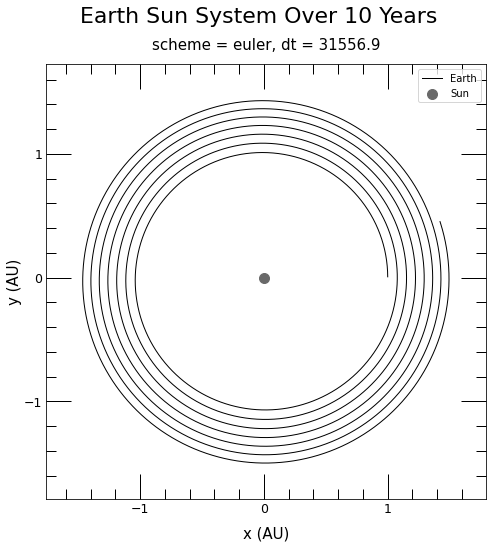

In [5]:
scheme = "euler"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

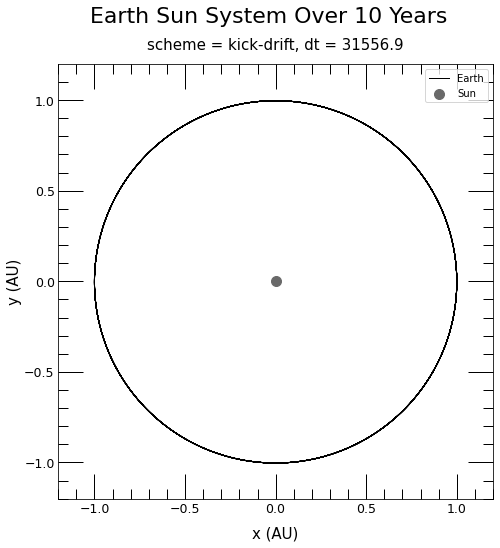

In [6]:
scheme = "kick-drift"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

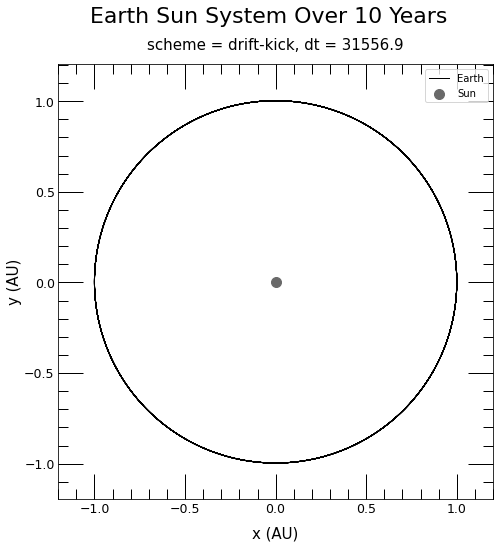

In [7]:
scheme = "drift-kick"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

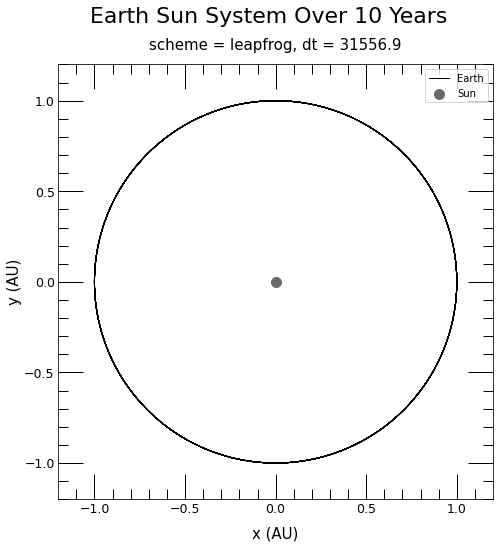

In [8]:
scheme = "leapfrog"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

### 100 Years

In [9]:
years = 100
nsteps = 10000
dt = years * yr / nsteps
print("For nsteps =",nsteps,"and years =",years,"dt =",dt)

For nsteps = 10000 and years = 100 dt = 315569.0


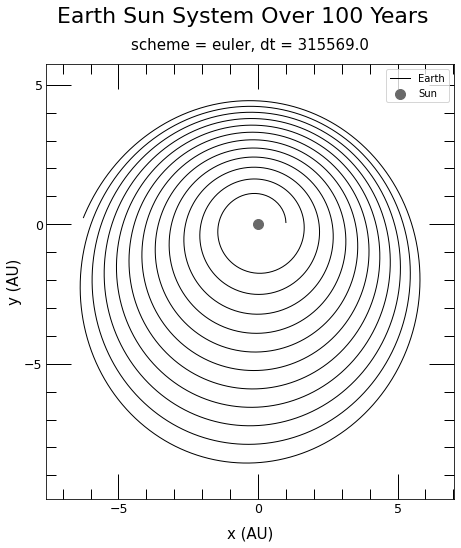

In [10]:
scheme = "euler"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

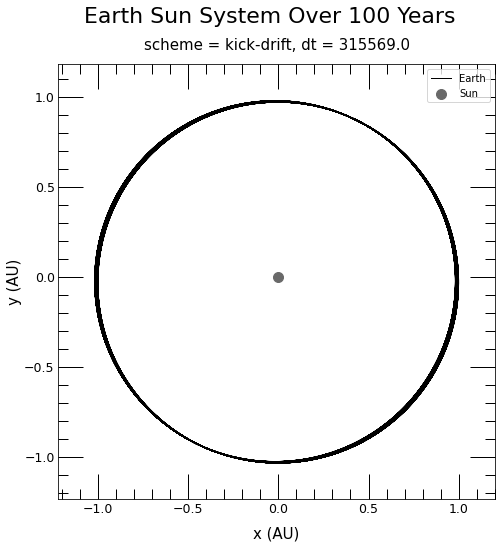

In [11]:
scheme = "kick-drift"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

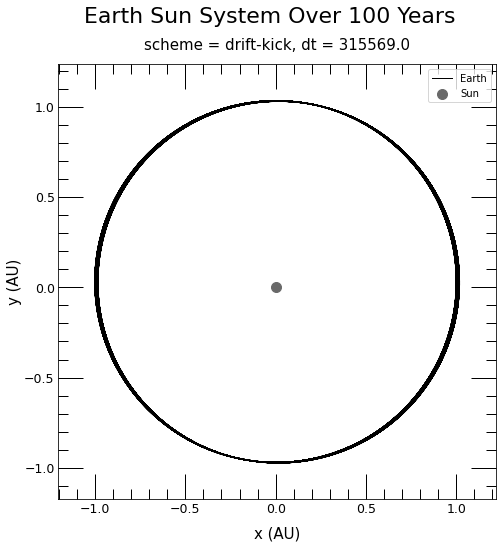

In [12]:
scheme = "drift-kick"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

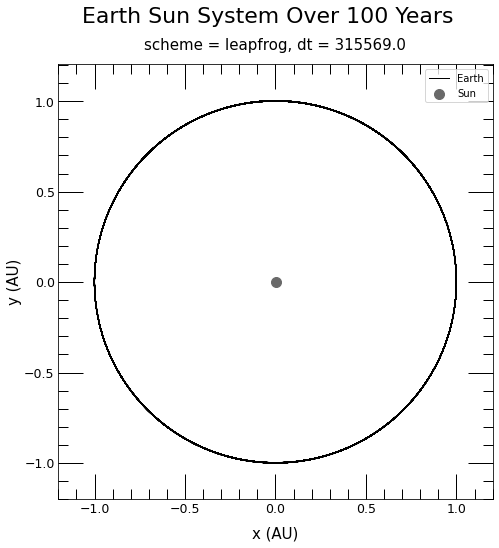

In [13]:
scheme = "leapfrog"
earth_sun_system.basic_topdown_plot(dt,nsteps,
                                    scheme=schemes[scheme],
                                    to_plot="xy",
                                    static_star=0,
                                    subtitle="scheme = " + scheme + ", dt = " + str(dt),
                                    title="Earth Sun System Over " + str(years) + " Years",
                                    x_label="x (AU)",
                                    y_label="y (AU)",
                                    scale=AU,
                                    colors=["dimgrey","black"])

<b>Simply from these plots, we can observe how leapfrog yields more accurate results than drift-kick and kick-drift, which both yield more accurate results than euler.</b>

## Plot distance plots for different dt
#### Specifically, I plot distance from Earth to the Center, the Sun to the Center, and the Earth to the Sun.

### `nsteps = 1000`, `years = 100`

In [14]:
years = 100
nsteps = 1000
dt = years * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 1000 and dt = 3155690.0


### <i>Scheme: 1st Order Euler</i>

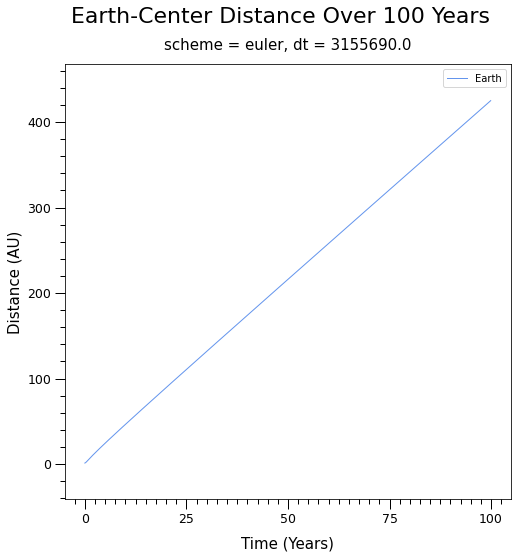

In [15]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

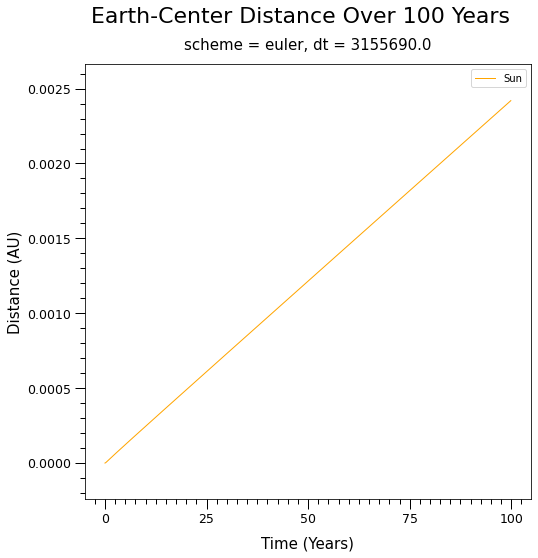

In [16]:
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

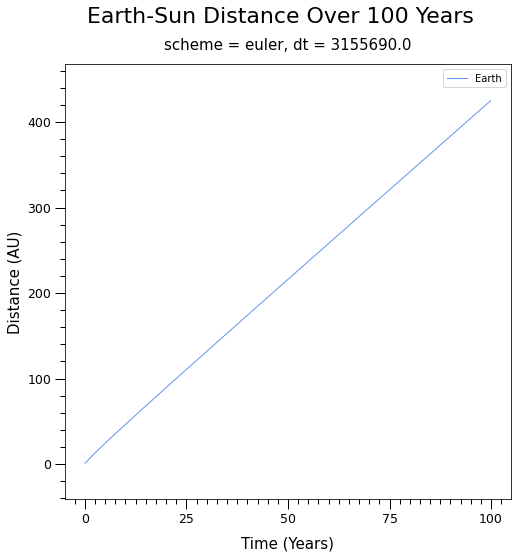

In [17]:
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### <i>Scheme: 1st Order Kick-Drift</i>

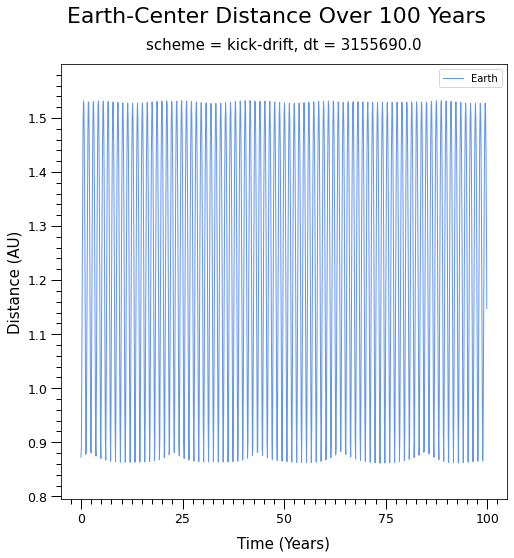

In [18]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

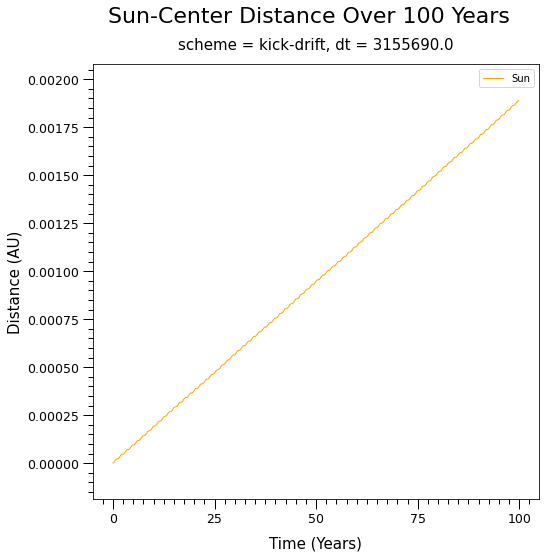

In [19]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Sun-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

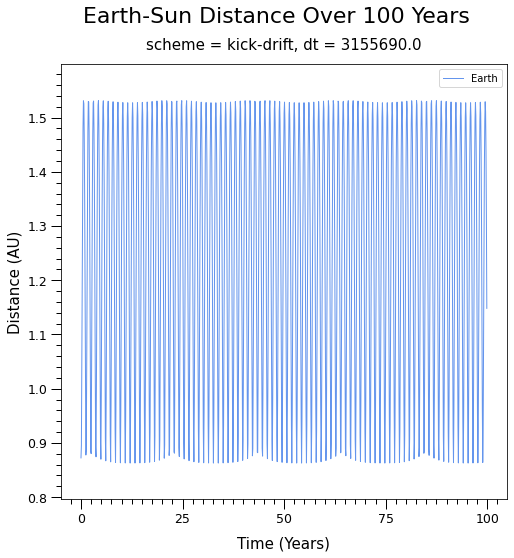

In [20]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### `nsteps = 10000`, `years = 100`

In [21]:
years = 100
nsteps = 10000
dt = years * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 10000 and dt = 315569.0


### <i>Scheme: 1st Order Euler</i>

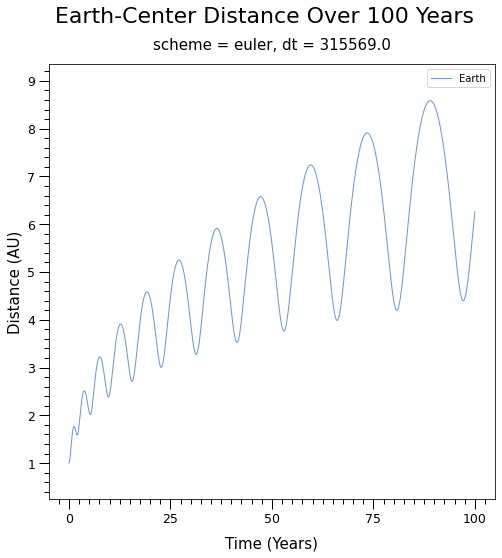

In [22]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

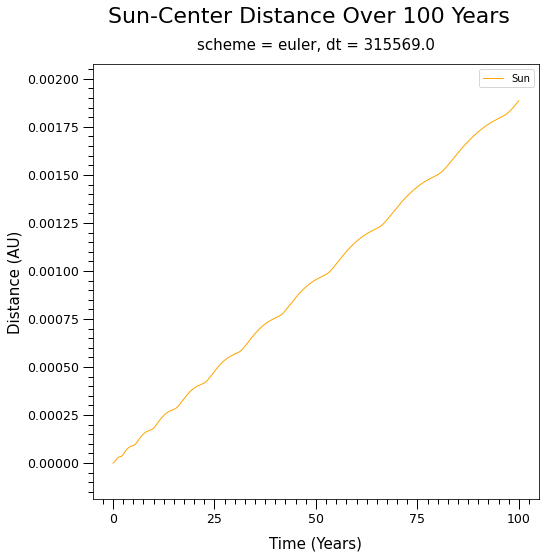

In [23]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Sun-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

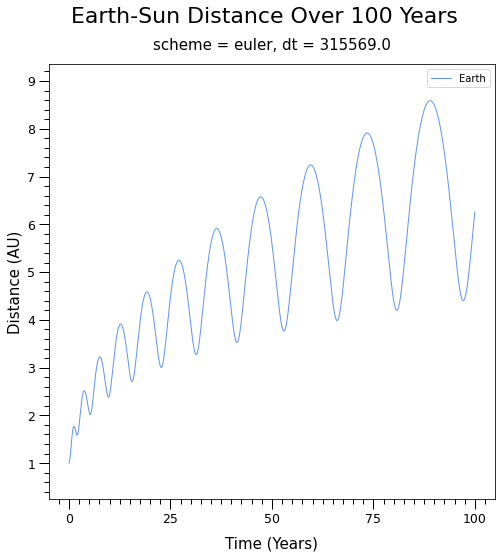

In [24]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### <i>Scheme: 1st Order Kick-Drift</i>

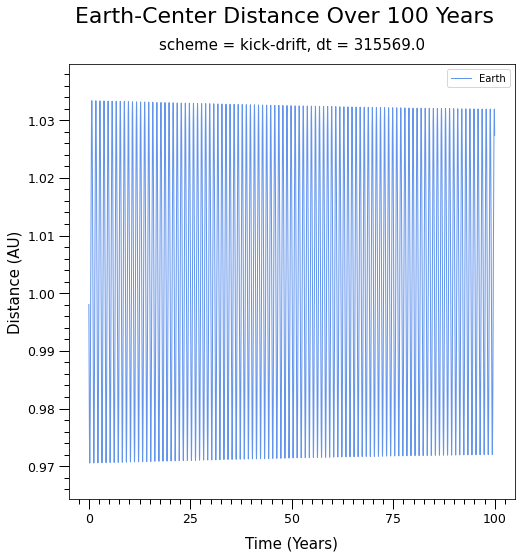

In [25]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

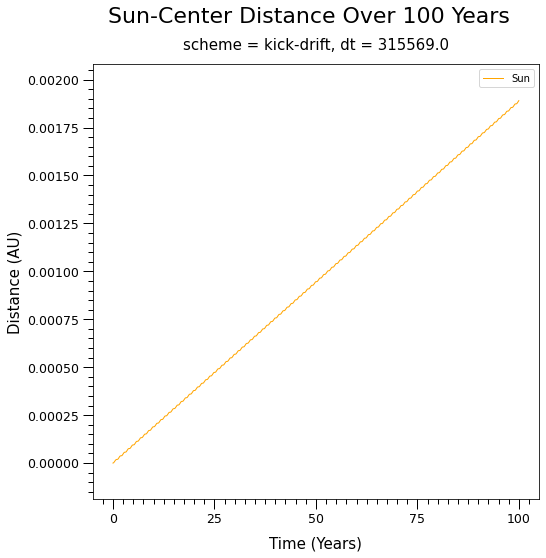

In [26]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Sun-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

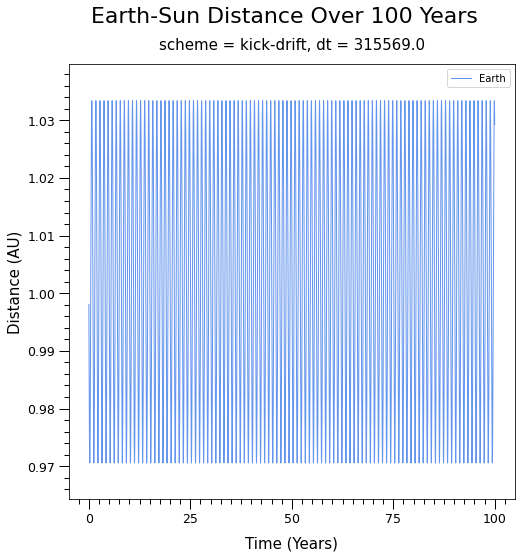

In [27]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### `nsteps = 100000`, `years = 10`

In [28]:
years = 10
nsteps = 100000
dt = years * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 100000 and dt = 3155.69


### <i>Scheme: 1st Order Euler</i>

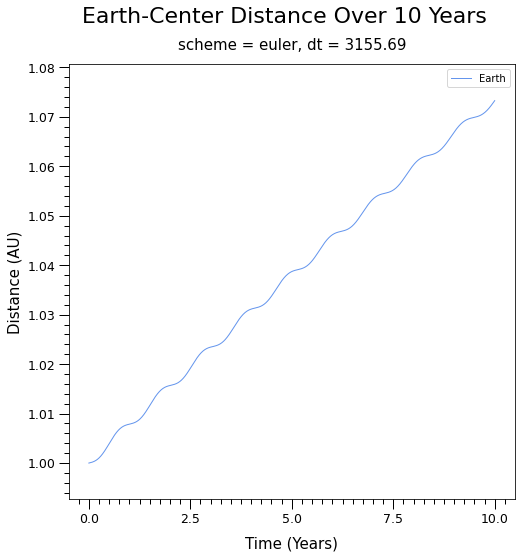

In [29]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

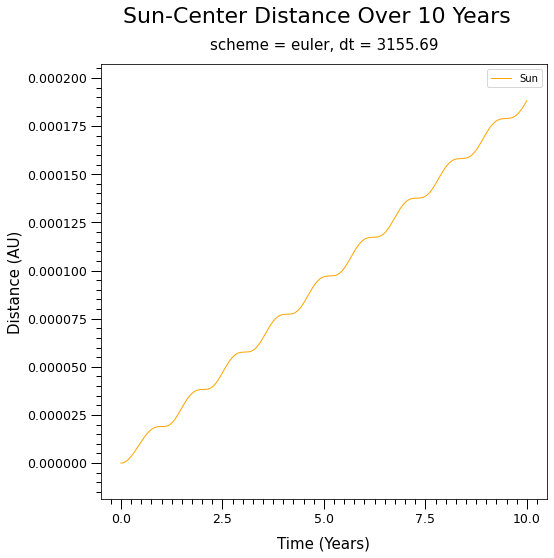

In [30]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Sun-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

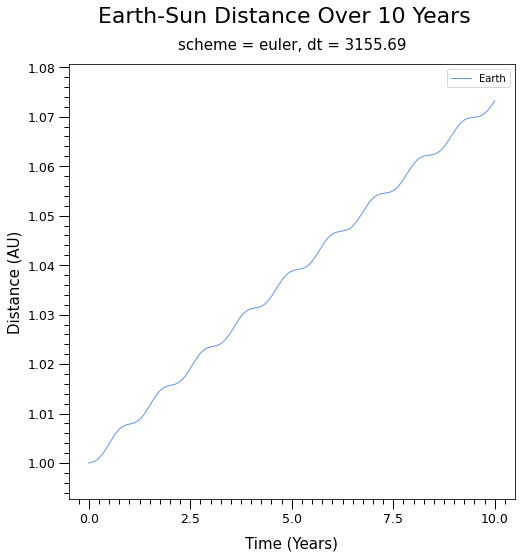

In [31]:
scheme = "euler"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### <i>Scheme: 1st Order Kick-Drift</i>

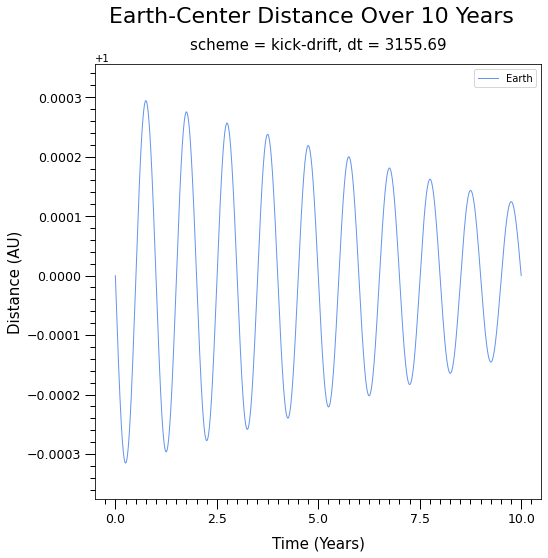

In [32]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

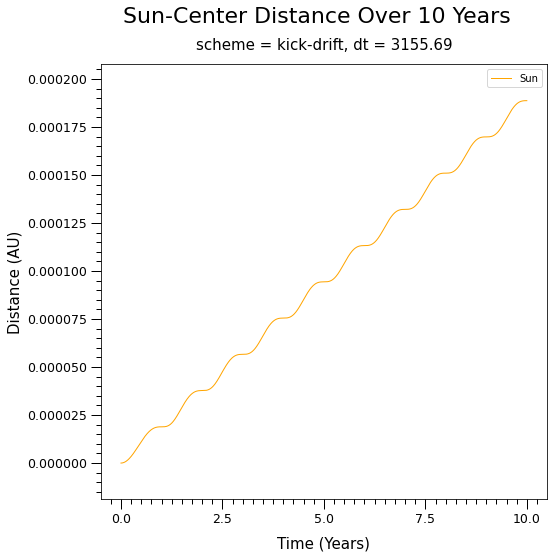

In [33]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Center",
                                to_plot=["Sun"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Sun-Center Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

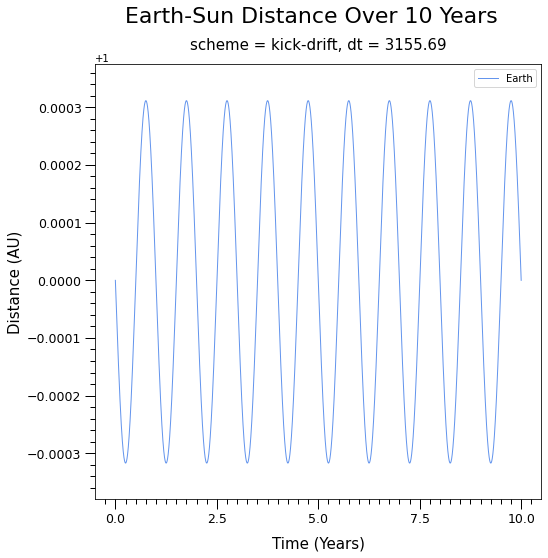

In [34]:
scheme = "kick-drift"
earth_sun_system.basic_d_t_plot(dt,nsteps,
                                scheme=schemes[scheme],
                                base_object="Sun",
                                to_plot=["Earth"],
                                distance_scale=AU,
                                time_scale=yr,
                                x_label="Time (Years)",
                                y_label="Distance (AU)",
                                title="Earth-Sun Distance Over " + str(years) + " Years",
                                subtitle="scheme = " + str(scheme) + ", dt = " + str(dt))

### Analysis
<b>It appears that for any given $dt$, kick-drift will yield more accurate results than euler. For $dt \approx 3\times10^6$, the simulation using euler is not even vaguely circular, while kick-drift gives somewhat of an orbit. At $dt \approx 3\times10^5$, euler gives an orbit that constantly increases in radius, while euler gives a fairly stable earth-sun distance. For $dt \approx 3\times10^3$, euler still gives an orbit that is constantly increasing in radius, while kick-drift gives a very stable earth-sun distance, but is still not completely circular. For the purposes of this simulation, $dt \approx 3\times10^5$ seems good enough for kick-drift, as it gives a stable earth-sun distance with not too much fluctuation which would give a circular-ish plot while keeping step-size low. For more accuracy, $dt \approx 3\times10^3$ would be better, but would increase step-size.</b>

### <font color='darkblue'>2. (10 points)  Integrating orbits of planets in the <a href="http://www.openexoplanetcatalogue.com/planet/Gliese%20876%20e/">exoplanet system GJ 876</a>
    
Note that if for some reason you will not be able to make your code in the exercise 1 above to work properly. I can provide you with a function to carry out this exercise. You will receive a partial credit for exercise 1, depending on how much progress you've made towards complete implementation. 
    
#### Required tests and follow up questions: 
Initialize the three body system (star and two planets) with these coordinates and velocities as initial conditions using data read in the code snippet below. Integrate them forward for 3320 days with the $N$-body code you implemented in the exercise 1 using your conclusions about the best scheme and step size from that exercise. 

Record positions and velocities of the planets and the star. Make a scatter plot of $x$ and $y$ coordinates (converted to the astronomical unit AU) of the star and planets in half-day intervals. Plot the $y$-component of velocity of the star as a function of time. Compare to Figures 1 and 2 in <a href="https://ui.adsabs.harvard.edu/abs/2005ApJ...622.1182L/abstract">Laughlin et al. 2005</a>. Can you reproduce the figures? We will discuss what these figures show in class. 

### Initialize System

In [35]:
try:
    data_file = 'https://astro.uchicago.edu/~andrey/classes/a211/data/gj876.dat'
    name = np.loadtxt(data_file, usecols=[0], unpack=True, dtype=str)
    mp, xp, yp, zp, vxp, vyp, vzp = np.loadtxt(data_file, usecols=(1,2,3,4,5,6,7), unpack=True)
    print("Loaded values from",data_file)
except:
    #so I could work offline/on another computer easily
    mp = np.array([6.36515181e32,1.13341374e30,3.59700414e30])
    xp = np.array([0.,-1.3739370e12,2.89833447e12])
    yp = np.array([0.,6.6185776e11,-1.3485766e12])
    zp = np.array([0.,0.,0.])
    vxp = np.array([-3.97415664e3,-2.53217478e6,1.50114165e6])
    vyp = np.array([-9.01247643e3,-5.26220995e6,3.25294014e6])
    vzp = np.array([0.,0.,0.])
    print("Loading hardcoded values")

start_date = 2449680
end_date = 2453000

plot_date = 2449710
plot_length = 60

steps = int(13280 * 2) #so that the number of steps for a half day is a whole number

print("nsteps =",steps)

x = np.column_stack((xp,yp,zp))
v = np.column_stack((vxp,vyp,vzp))

gj876 = simulation(x,v,mp,object_names = ["Star","Planet 1","Planet 2"])

Loaded values from https://astro.uchicago.edu/~andrey/classes/a211/data/gj876.dat
nsteps = 26560


### Plots
<b> Because leapfrog gives the highest accuracy, the plots all use the leapfrog scheme.</b>


(I spent far too long trying to make these plots look like the plots in the paper)

### <i>Plot $x$ pos against $y$ pos</i>

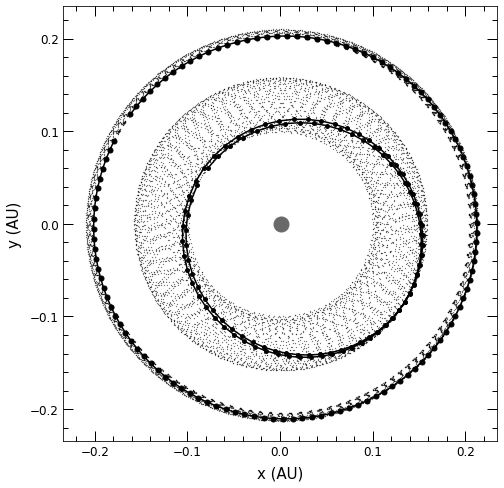

In [36]:
gj876.laughlin_topdown_plot(steps,
                            start_date,
                            end_date,
                            plot_date,
                            plot_length,
                            scheme=schemes["leapfrog"],
                            star="Star",
                            sizes=[15,25])

### <i>Plot $y$ velocity against time</i>

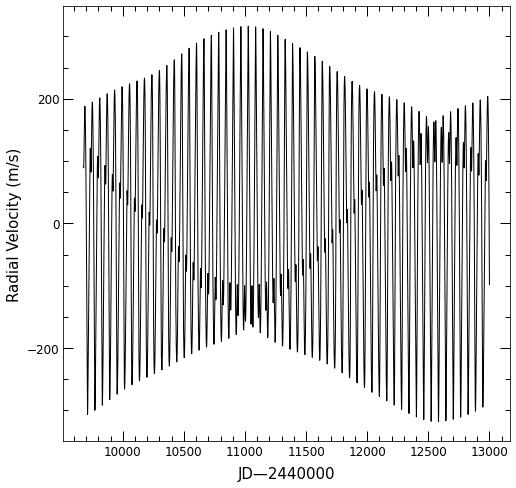

In [37]:
gj876.laughlin_velocity_time(steps,
                             start_date,
                             end_date,
                             scheme = schemes["leapfrog"],
                             plot_offset = 2440000,
                             component="y",
                             flip=True) #plot is flipped because direction doesn't matter and I wanted it to look like the paper